## For Data Cleaning and File Generation Purposes

In [2]:
import numpy as np
import pandas as pd
import geopandas
from rasterio import features
from rasterio.plot import show
import matplotlib.pyplot as plt
import rasterio
import os
from sklearn.model_selection import train_test_split

In [3]:
#using numpy to deallocate pixels
def parseMTL(path):
    mtl_dict = {}
    with open(path, "r") as file:
        for i in file:
            if "=" in i:
                key, value = line.strip().split(' = ')
                value = value.strip('"')
            try:
                value = float(value)
            except ValueError:
                pass
            mtl_dict[key] = value
    return mtl_dict

In [4]:
data_path = "data/"

nir_path = "LC08_L2SP_116050_20240306_20240315_02_T1_SR_B5.TIF"
swir_path = "LC08_L2SP_116050_20240306_20240315_02_T1_SR_B6.TIF"

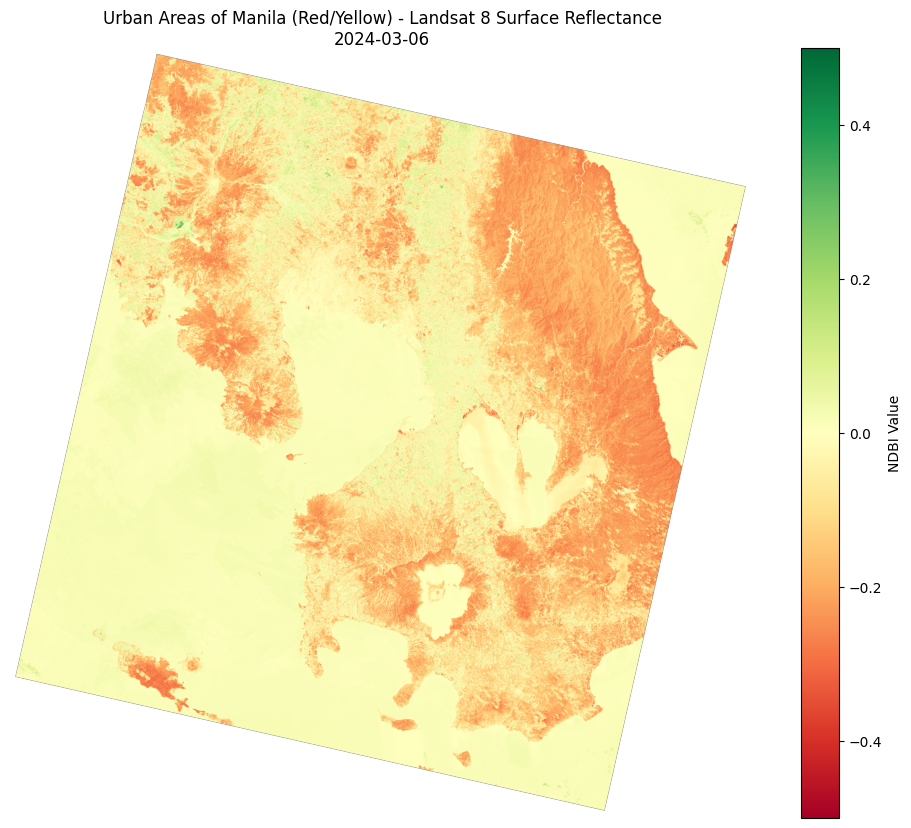

Analysis complete! Red/Yellow pixels indicate built-up areas.


In [5]:
with rasterio.open(nir_path) as src:
    nir = src.read(1).astype('float32')
    profile = src.profile  # Save the geographic info for later

with rasterio.open(swir_path) as src:
    swir = src.read(1).astype('float32')

with np.errstate(divide='ignore', invalid='ignore'):
    ndbi = (swir - nir) / (swir + nir)
    ndbi = np.clip(ndbi, -1, 1)  # Keep values between -1 and 1

# 4. VISUALIZE THE RESULT
plt.figure(figsize=(12, 10))
# Use a colormap where red/yellow = urban, green = vegetation, blue = water
im = plt.imshow(ndbi, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.colorbar(im, label='NDBI Value')
plt.title('Urban Areas of Manila (Red/Yellow) - Landsat 8 Surface Reflectance\n2024-03-06')
plt.axis('off')
#plt.savefig("Urban Areas of Manila.png")
plt.show()

print("Analysis complete! Red/Yellow pixels indicate built-up areas.")

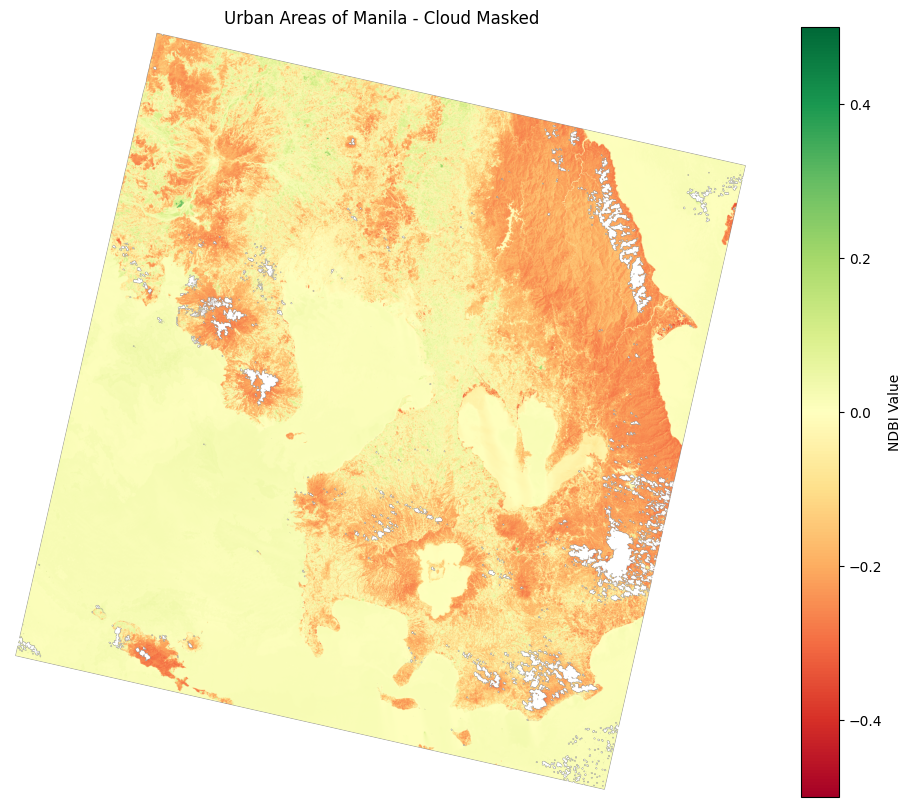

In [6]:
# Path to the quality band
qa_path = "LC08_L2SP_116050_20240306_20240315_02_T1_QA_PIXEL.TIF"

# Function to mask clouds based on the QA_PIXEL band
def mask_clouds(qa_band):
    # Define bit masks from the Landsat QA_PIXEL band
    # Bit 3 = Cloud Shadow, Bit 4 = Snow, Bit 5 = Cloud
    cloud_shadow_mask = 1 << 3   #  (8)
    snow_mask = 1 << 4           # (16)
    cloud_mask = 1 << 5          # (32)
    # Combine masks: if any of these bits are set, it's a bad pixel
    mask = (qa_band & cloud_shadow_mask) | (qa_band & snow_mask) | (qa_band & cloud_mask)
    return mask == 0  # Return True for clear pixels, False for cloudy pixels

# Apply the cloud mask
with rasterio.open(qa_path) as src:
    qa = src.read(1)

clear_mask = mask_clouds(qa) # Create a mask of clear pixels

# Apply the mask to your NDBI array: set cloudy pixels to NaN so they don't display
ndbi_cloud_masked = np.where(clear_mask, ndbi, np.nan)

# Plot the cloud-masked result
plt.figure(figsize=(12, 10))
im = plt.imshow(ndbi_cloud_masked, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.colorbar(im, label='NDBI Value')
plt.title('Urban Areas of Manila - Cloud Masked')
plt.axis('off')
#plt.savefig("Urban Areas of Manila - Cloud Masked.png")
plt.show()

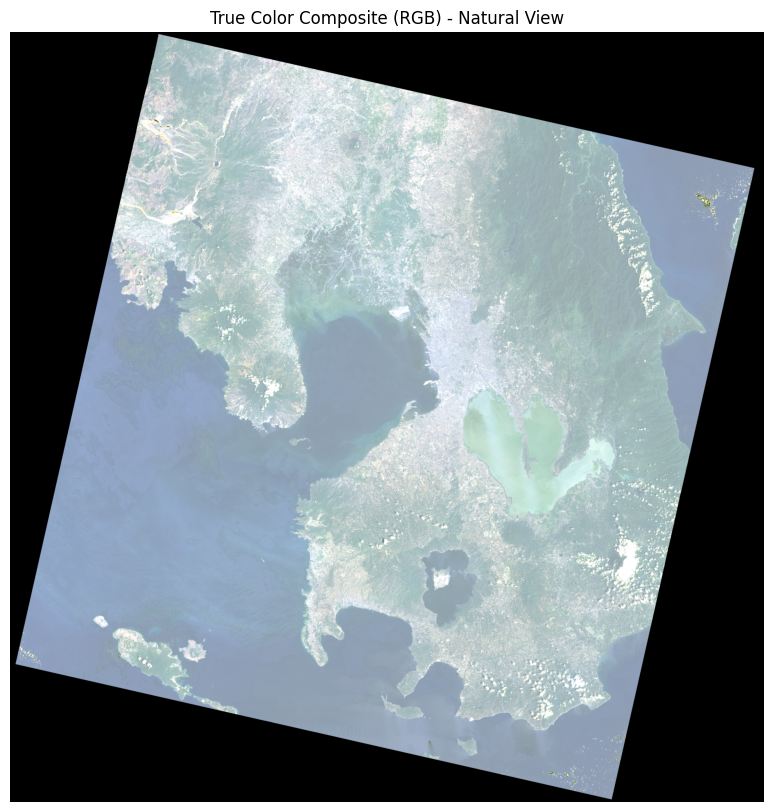

In [7]:
# Load RGB bands
red_path =  "LC08_L2SP_116050_20240306_20240315_02_T1_SR_B4.TIF"
green_path = "LC08_L2SP_116050_20240306_20240315_02_T1_SR_B3.TIF"
blue_path =  "LC08_L2SP_116050_20240306_20240315_02_T1_SR_B2.TIF"

with rasterio.open(red_path) as src:
    red = src.read(1)
with rasterio.open(green_path) as src:
    green = src.read(1)
with rasterio.open(blue_path) as src:
    blue = src.read(1)

# Create RGB composite
rgb = np.dstack((red, green, blue))

# Scale for better visualization (2% linear stretch)
def stretch_image(img, lower_percent=2, upper_percent=98):
    lower = np.percentile(img[~np.isnan(img)], lower_percent)
    upper = np.percentile(img[~np.isnan(img)], upper_percent)
    img_stretched = (img - lower) / (upper - lower)
    img_stretched = np.clip(img_stretched, 0, 1)
    return img_stretched

rgb_stretched = np.dstack((stretch_image(red), stretch_image(green), stretch_image(blue)))

plt.figure(figsize=(12, 10))
plt.imshow(rgb_stretched)
plt.title('True Color Composite (RGB) - Natural View')
plt.axis('off')
plt.savefig("True Color Composite (RGB) - Natural View.png")
plt.show()

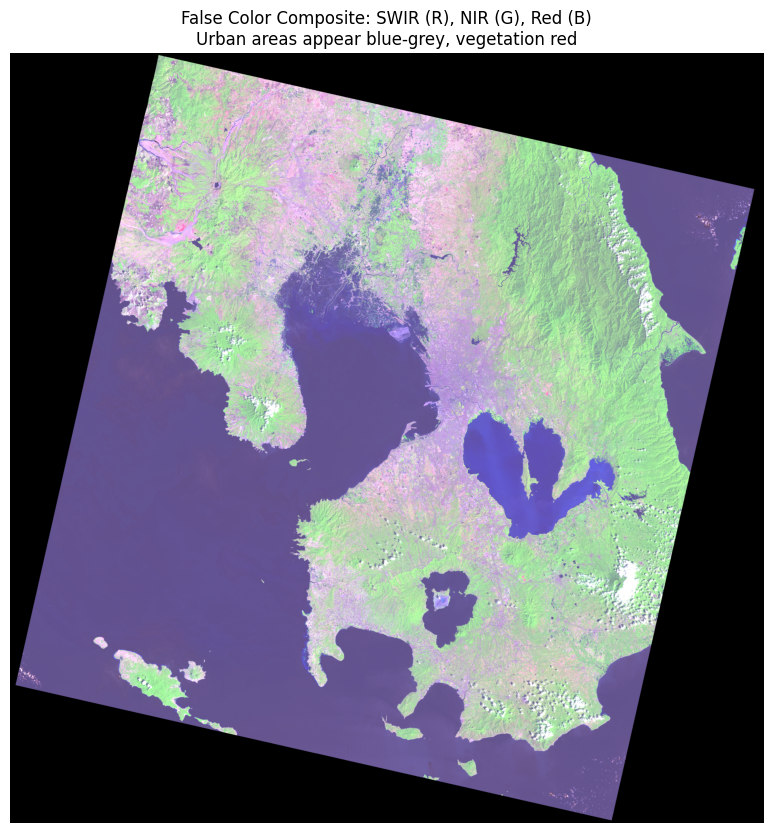

In [8]:
# Urban false color: SWIR1, NIR, Red
urban_false_color = np.dstack((swir, nir, red))  # SWIR, NIR, Red

# Apply stretching to each band
urban_stretched = np.dstack((stretch_image(swir), stretch_image(nir), stretch_image(red)))

plt.figure(figsize=(12, 10))
plt.imshow(urban_stretched)
plt.title('False Color Composite: SWIR (R), NIR (G), Red (B)\nUrban areas appear blue-grey, vegetation red')
plt.axis('off')
#plt.savefig("False Color Composite Vegetation.png")
plt.show()

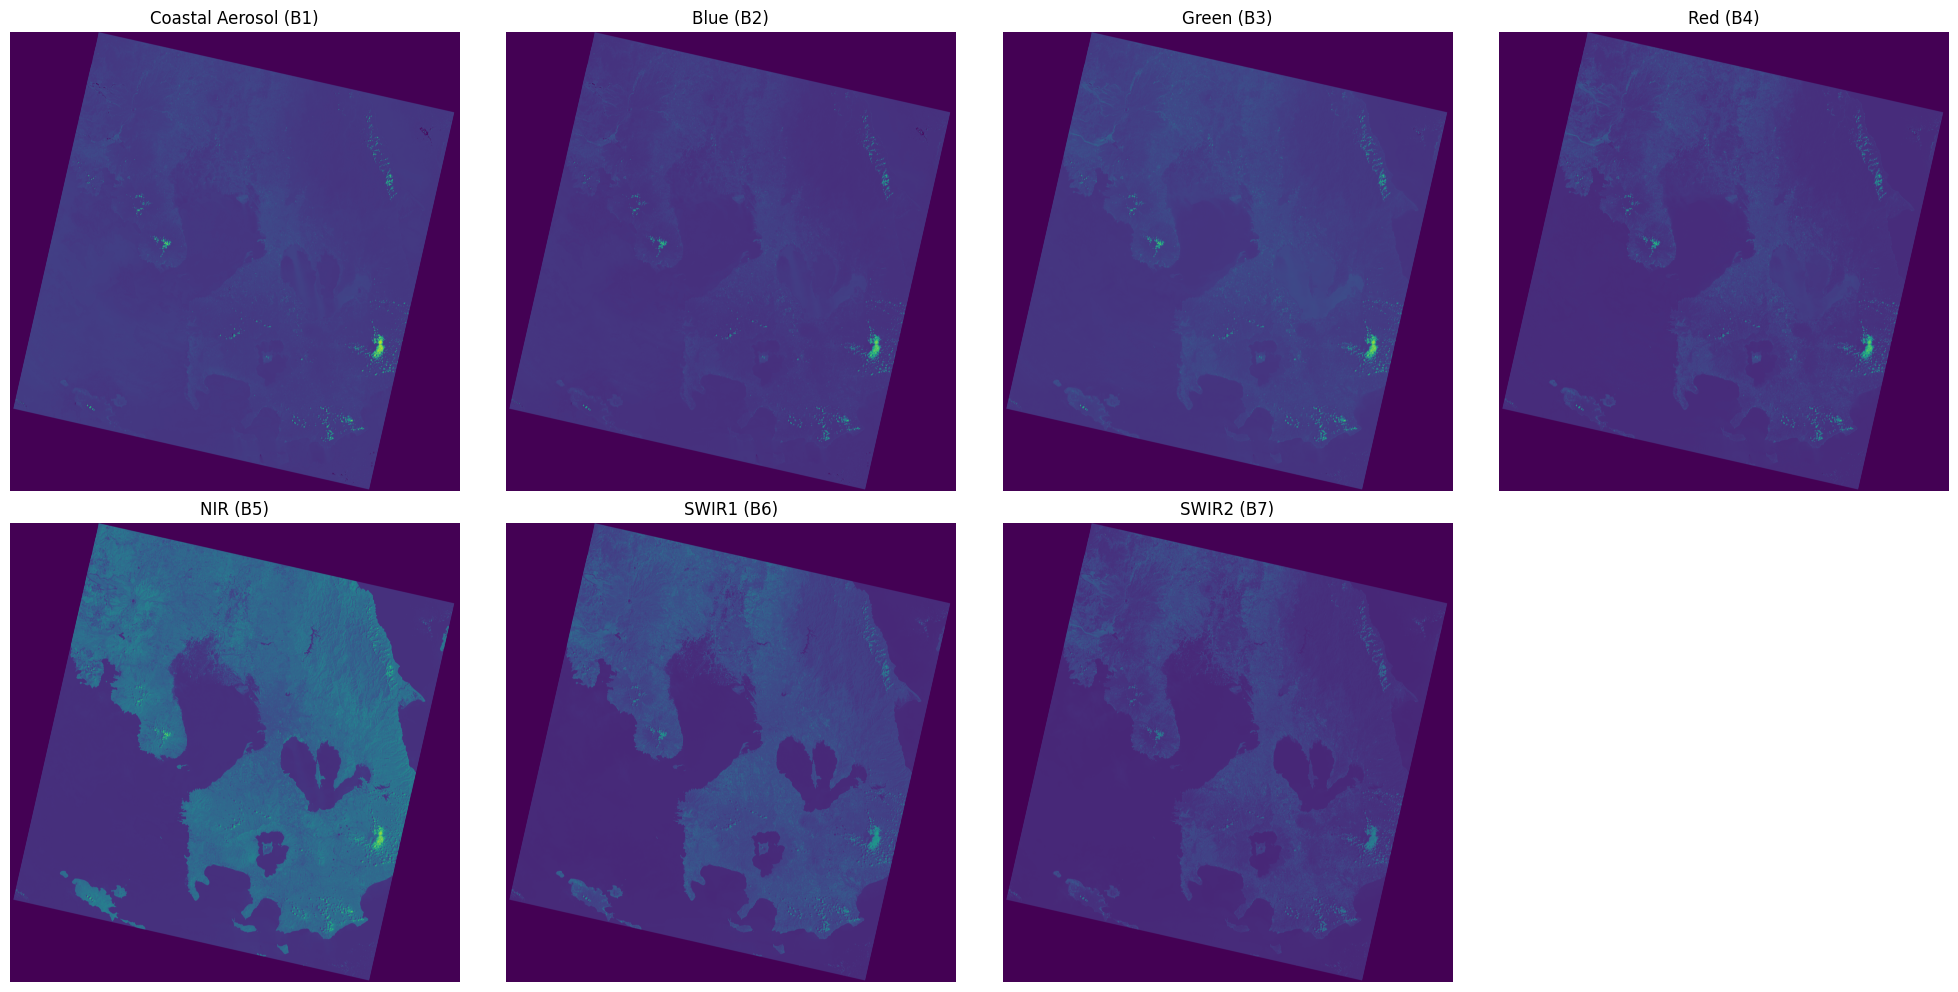

In [9]:
bands_to_visualize = {
    'Coastal Aerosol (B1)': 'SR_B1',
    'Blue (B2)': 'SR_B2',
    'Green (B3)': 'SR_B3',
    'Red (B4)': 'SR_B4',
    'NIR (B5)': 'SR_B5',
    'SWIR1 (B6)': 'SR_B6',
    'SWIR2 (B7)': 'SR_B7'
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, (title, band_code) in enumerate(bands_to_visualize.items()):
    band_path = "LC08_L2SP_116050_20240306_20240315_02_T1_{band_code}.TIF".format(band_code=band_code)
    with rasterio.open(band_path) as src:
        band_data = src.read(1)

    axes[i].imshow(band_data, cmap='viridis')
    axes[i].set_title(title)
    axes[i].axis('off')

# Hide the empty subplot
axes[7].set_visible(False)
plt.tight_layout()
#plt.savefig("All Bands.png")
plt.show()

In [6]:
#Now we are creating the dataset
band_files = {
    'B1': 'SR_B1', 'B2': 'SR_B2', 'B3': 'SR_B3', 'B4': 'SR_B4',
    'B5': 'SR_B5', 'B6': 'SR_B6', 'B7': 'SR_B7',
    'QA': 'QA_PIXEL'
}

#LOAD ALL BANDS INTO A DICTIONARY
print("Loading all bands...")
bands_data = {}
for band_name, band_code in band_files.items():
    file_path = "LC08_L2SP_116050_20240306_20240315_02_T1_{band_code}.TIF".format(band_code=band_code)
    with rasterio.open(file_path) as src:
        bands_data[band_name] = src.read(1)
        if band_name == 'B2':  # Use one band for profile
            profile = src.profile

print("All bands loaded successfully!")

#(FEATURE ENGINEERING)
print("Calculating spectral indices...")
with np.errstate(divide='ignore', invalid='ignore'):
    # Basic indices
    ndvi = (bands_data['B5'] - bands_data['B4']) / (bands_data['B5'] + bands_data['B4'])
    ndbi = (bands_data['B6'] - bands_data['B5']) / (bands_data['B6'] + bands_data['B5'])
    ndwi = (bands_data['B3'] - bands_data['B5']) / (bands_data['B3'] + bands_data['B5'])
    savi = ((bands_data['B5'] - bands_data['B4']) / (bands_data['B5'] + bands_data['B4'] + 0.5)) * 1.5

    # Additional features
    brightness = (bands_data['B4'] + bands_data['B5'] + bands_data['B6']) / 3
    ratio_swir_nir = bands_data['B6'] / bands_data['B5']
    ratio_nir_red = bands_data['B5'] / bands_data['B4']

#CREATE MASK FOR VALID PIXELS (remove clouds, water, etc.)
print("Creating mask for valid pixels...")
qa = bands_data['QA']
cloud_mask = (qa & (1 << 5)) == 0  # Clear of clouds
shadow_mask = (qa & (1 << 3)) == 0  # Clear of cloud shadows
valid_mask = cloud_mask & shadow_mask

# Get coordinates for valid pixels
y_coords, x_coords = np.where(valid_mask)
print(f"Total valid pixels: {len(y_coords)}")

#SAMPLE POINTS (to avoid huge DataFrame) to save us the fuckin time  bruh
sample_size = 50000  # Adjust based on your RAM
if len(y_coords) > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(len(y_coords), sample_size, replace=False)
    y_sample = y_coords[sample_indices]
    x_sample = x_coords[sample_indices]
else:
    y_sample, x_sample = y_coords, x_coords

print(f"Sampling {len(y_sample)} pixels for DataFrame")

# 6. CREATE THE DATAFRAME
print("Creating DataFrame...")
data = []

for i, (y, x) in enumerate(zip(y_sample, x_sample)):
    if i % 10000 == 0:
        print(f"Processing pixel {i}/{len(y_sample)}")

    pixel_data = {
        'pixel_id': i,
        'row': y,
        'col': x,
        # Raw band values
        'B1_coastal': bands_data['B1'][y, x],
        'B2_blue': bands_data['B2'][y, x],
        'B3_green': bands_data['B3'][y, x],
        'B4_red': bands_data['B4'][y, x],
        'B5_nir': bands_data['B5'][y, x],
        'B6_swir1': bands_data['B6'][y, x],
        'B7_swir2': bands_data['B7'][y, x],
        # Spectral indices
        'NDVI': ndvi[y, x],
        'NDBI': ndbi[y, x],
        'NDWI': ndwi[y, x],
        'SAVI': savi[y, x],
        # Additional features
        'brightness': brightness[y, x],
        'ratio_swir_nir': ratio_swir_nir[y, x],
        'ratio_nir_red': ratio_nir_red[y, x]
    }
    data.append(pixel_data)

#CREATE PANDAS DATAFRAME
df = pd.DataFrame(data)
df.to_csv("manila_landsat_data.csv")
print("DataFrame created successfully!")
print(f"DataFrame shape: {df.shape}")
print("\nDataFrame columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Loading all bands...
All bands loaded successfully!
Calculating spectral indices...
Creating mask for valid pixels...
Total valid pixels: 59029120
Sampling 50000 pixels for DataFrame
Creating DataFrame...
Processing pixel 0/50000
Processing pixel 10000/50000
Processing pixel 20000/50000
Processing pixel 30000/50000
Processing pixel 40000/50000
DataFrame created successfully!
DataFrame shape: (50000, 17)

DataFrame columns:
['pixel_id', 'row', 'col', 'B1_coastal', 'B2_blue', 'B3_green', 'B4_red', 'B5_nir', 'B6_swir1', 'B7_swir2', 'NDVI', 'NDBI', 'NDWI', 'SAVI', 'brightness', 'ratio_swir_nir', 'ratio_nir_red']

First few rows:
   pixel_id   row   col  B1_coastal  B2_blue  B3_green  B4_red  B5_nir  \
0         0  2695  4024        8586     8700      9131    8971    9244   
1         1  1145  4302        8197     8646     10138    9818   19031   
2         2   320  3263           0        0         0       0       0   
3         3  7152  5436        7680     7773      7775    7615    7752 